In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

### Defining Transforms 
Resize → model compatibility

Augmentation → generalization

Normalization → stable training

```python
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])


In [53]:
from torchvision.datasets import ImageFolder

data_dir = "data"

full_dataset = ImageFolder(
    root=data_dir,
    transform=None
)


print("Classes:", full_dataset.classes)
print("Number of images:", len(full_dataset))


Classes: ['citrus_black_spot', 'citrus_canker', 'citrus_foliage_damage', 'citrus_greening', 'citrus_healthy', 'citrus_mealybugs', 'citrus_melanose', 'mango_anthracnose', 'mango_bacterial_canker', 'mango_cutting_weevil', 'mango_die_back', 'mango_gall_midge', 'mango_healthy', 'mango_powdery_mildew', 'mango_sooty_mould']
Number of images: 30626


In [54]:
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size


train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size]
)

In [55]:
from collections import Counter
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(train_labels)

print("\nTraining class distribution:")
for cls_idx, count in class_counts.items():
    print(f"{full_dataset.classes[cls_idx]:35s}: {count}")



Training class distribution:
citrus_melanose                    : 2044
citrus_canker                      : 9002
citrus_mealybugs                   : 3119
citrus_healthy                     : 5114
citrus_foliage_damage              : 1680
mango_powdery_mildew               : 404
mango_bacterial_canker             : 407
mango_anthracnose                  : 396
mango_healthy                      : 406
mango_cutting_weevil               : 415
mango_die_back                     : 392
citrus_greening                    : 176
citrus_black_spot                  : 139
mango_sooty_mould                  : 398
mango_gall_midge                   : 408


In [56]:
RARE_THRESHOLD = 200

rare_classes = {
    cls_idx for cls_idx, count in class_counts.items()
    if count < RARE_THRESHOLD
}

print("\nRare classes:")
for cls_idx in rare_classes:
    print(full_dataset.classes[cls_idx])



Rare classes:
citrus_black_spot
citrus_greening


In [57]:
from torchvision import transforms

light_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



In [58]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


`- Note that only "training" is agumented, while "validation/test" is only resize and normalized.`

### Loading Dataset

In [59]:
from torch.utils.data import Dataset

class ClassAwareDataset(Dataset):
    def __init__(self, subset, rare_classes,
                 light_transform, strong_transform):
        self.subset = subset
        self.rare_classes = rare_classes
        self.light_transform = light_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        dataset = self.subset.dataset          # ImageFolder
        real_idx = self.subset.indices[idx]    # real index inside ImageFolder

        path, label = dataset.samples[real_idx]
        img = dataset.loader(path)             # ALWAYS PIL Image

        if label in self.rare_classes:
            img = self.strong_transform(img)
        else:
            img = self.light_transform(img)

        return img, label


### Train/Validation Split

In [60]:
from torch.utils.data import random_split



# Class-aware training dataset
train_dataset = ClassAwareDataset(
    train_dataset,
    rare_classes,
    light_transform,
    strong_transform
)

# Validation transform
val_dataset.dataset.transform = val_transform
val_dataset = val_dataset

In [61]:
from torch.utils.data import WeightedRandomSampler
num_classes = len(full_dataset.classes)

class_weights = np.zeros(num_classes)
for cls_idx, count in class_counts.items():
    class_weights[cls_idx] = 1.0 / count

class_weights = class_weights / class_weights.sum()

sample_weights = [
    class_weights[label] for label in train_labels
]

sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


### Creating DataLoaders

In [62]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False, # Avoids Learning order bias
    num_workers=4, # For faster loading
    pin_memory=True # For faster GPU transfer
)


### Pre-training Sanity Check

```python

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


### Class Balance Check

In [63]:
import os
for idx, class_name in enumerate(full_dataset.classes):
    class_path = os.path.join(data_dir, class_name)
    count = len(os.listdir(class_path)) if os.path.isdir(class_path) else 0

    print(f"{class_name:35} : {count:5d}")



citrus_black_spot                   :   171
citrus_canker                       : 11248
citrus_foliage_damage               :  2100
citrus_greening                     :   204
citrus_healthy                      :  6384
citrus_mealybugs                    :  3919
citrus_melanose                     :  2600
mango_anthracnose                   :   500
mango_bacterial_canker              :   500
mango_cutting_weevil                :   500
mango_die_back                      :   500
mango_gall_midge                    :   500
mango_healthy                       :   500
mango_powdery_mildew                :   500
mango_sooty_mould                   :   500


### Baseline CNN

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # -------- Feature extractor --------
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # -------- Classifier --------
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
from torchvision import models

def get_model(num_classes):
    model = models.resnet18(weights="IMAGENET1K_V1")

    # Freeze feature extractor
    #for param in model.parameters():
        #param.requires_grad = False

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

    
    # Replace classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


In [66]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, dataloader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [ ]:
import torch.optim as optim
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(full_dataset.classes)
model = get_model(num_classes).to(device)  # Or use get_model(num_classes)
# Compute class weights (inverse frequency)
class_counts = np.bincount([label for _, label in full_dataset.imgs])
weights = 1.0 / (class_counts + 1e-6)
weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
# optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},        # head (fast)
    {'params': model.layer4.parameters(), 'lr': 1e-4}     # backbone (slow)
])

num_epochs = 10
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/15 | Train Loss: 0.4902 | Train Acc: 0.7880 | Val Loss: 0.2980 | Val Acc: 0.8578
Epoch 2/15 | Train Loss: 0.2057 | Train Acc: 0.9278 | Val Loss: 0.2028 | Val Acc: 0.9283
Epoch 3/15 | Train Loss: 0.1733 | Train Acc: 0.9433 | Val Loss: 0.1740 | Val Acc: 0.9427
Epoch 4/15 | Train Loss: 0.1581 | Train Acc: 0.9464 | Val Loss: 0.1494 | Val Acc: 0.9407
Epoch 5/15 | Train Loss: 0.1498 | Train Acc: 0.9495 | Val Loss: 0.1463 | Val Acc: 0.9435
Epoch 6/15 | Train Loss: 0.1386 | Train Acc: 0.9539 | Val Loss: 0.1332 | Val Acc: 0.9576
Epoch 7/15 | Train Loss: 0.1381 | Train Acc: 0.9555 | Val Loss: 0.1386 | Val Acc: 0.9553
Epoch 8/15 | Train Loss: 0.1374 | Train Acc: 0.9563 | Val Loss: 0.1237 | Val Acc: 0.9610
Epoch 9/15 | Train Loss: 0.1370 | Train Acc: 0.9553 | Val Loss: 0.1224 | Val Acc: 0.9621
Epoch 10/15 | Train Loss: 0.1389 | Train Acc: 0.9558 | Val Loss: 0.1207 | Val Acc: 0.9607
Epoch 11/15 | Train Loss: 0.1224 | Train Acc: 0.9584 | Val Loss: 0.1198 | Val Acc: 0.9608
Epoch 12/15 | Train

### Visualize Training and Validation Curves

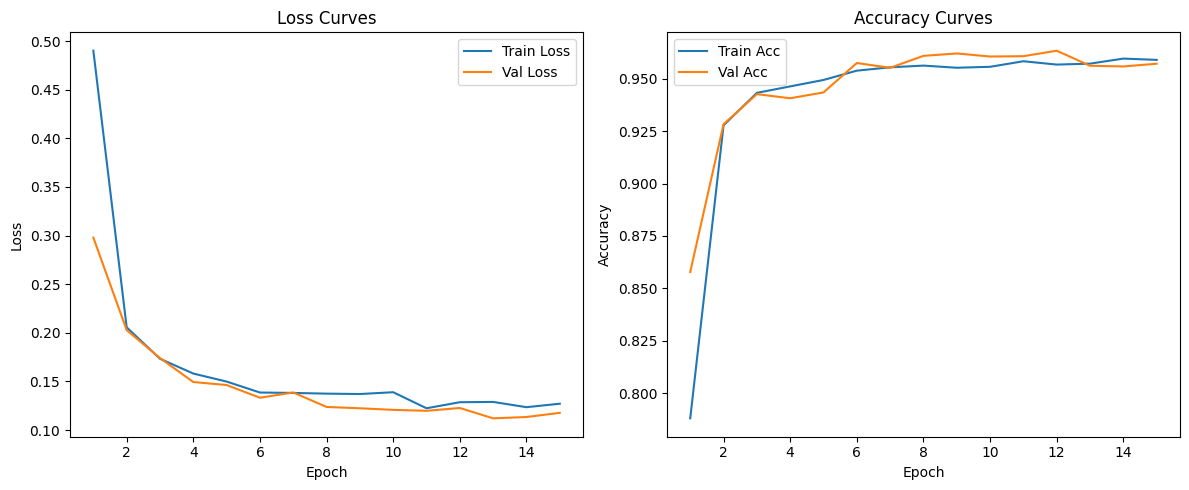

In [68]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate Best Model and Show Sample Predictions

              precision    recall  f1-score   support

           0       0.69      0.84      0.76        32
           1       0.99      0.99      0.99      2246
           2       0.78      0.85      0.81       420
           3       0.86      0.64      0.73        28
           4       0.99      0.98      0.98      1270
           5       0.92      0.88      0.90       800
           6       1.00      1.00      1.00       556
           7       0.98      1.00      0.99       104
           8       1.00      1.00      1.00        93
           9       1.00      1.00      1.00        85
          10       1.00      1.00      1.00       108
          11       0.99      1.00      0.99        92
          12       1.00      1.00      1.00        94
          13       0.99      1.00      0.99        96
          14       0.98      0.99      0.99       102

    accuracy                           0.96      6126
   macro avg       0.94      0.94      0.94      6126
weighted avg       0.96   

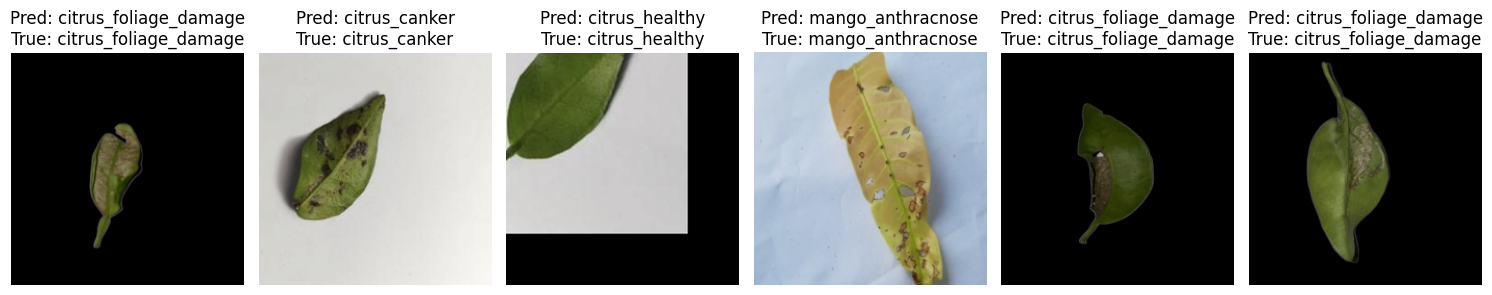

In [69]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
evaluate(model, val_loader, device)  # Print classification report and confusion matrix
import random
def show_sample_predictions(model, dataloader, class_names, device, num_samples=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break
                img = images[i].cpu().numpy().transpose(1,2,0)
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                plt.subplot(1, num_samples, images_shown+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
                images_shown += 1
            if images_shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()
# Show predictions on validation set
show_sample_predictions(model, val_loader, full_dataset.classes, device)

### Inference on a Custom Image

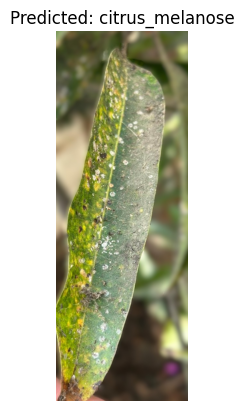

Predicted class: citrus_melanose


In [71]:
from PIL import Image
def predict_image(model, image_path, transform, class_names, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_t)
        pred = torch.argmax(output, dim=1).item()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred]}")
    plt.show()
    print(f"Predicted class: {class_names[pred]}")
# Example usage:
predict_image(model, "C:\\Users\\loaim\\OneDrive\\Desktop\\img1.jpeg", val_transform, full_dataset.classes, device)

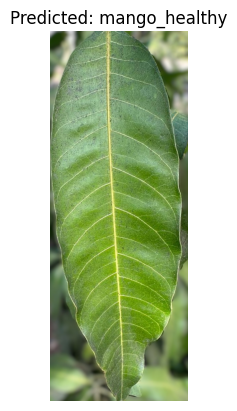

Predicted class: mango_healthy


In [72]:
predict_image(model, "C:\\Users\\loaim\\OneDrive\\Desktop\\img2.jpeg", val_transform, full_dataset.classes, device)

### Grad-CAM


In [73]:
import cv2


def prepare_image(image_path, transform, device):
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor

def overlay_cam(image, cam, alpha=0.5):
    img = np.array(image).astype(np.float32) / 255.0
    h, w, _ = img.shape
    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)
    return np.uint8(overlay * 255)

In [74]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_input, grad_output):
            # grad_output is a tuple; take the first element
            self.gradients = grad_output[0]
        # register hooks
        self.target_layer.register_forward_hook(forward_hook)
        # use full_backward_hook for modern PyTorch to get proper gradients
        try:
            self.target_layer.register_full_backward_hook(backward_hook)
        except Exception:
            # fallback (older versions)
            self.target_layer.register_backward_hook(backward_hook)
    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        # Forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = int(output.argmax(dim=1).item())
        # Backward pass on the selected class score
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward(retain_graph=True)
        # Ensure hooks captured values
        if self.gradients is None or self.activations is None:
            raise RuntimeError('Gradients or activations not captured — check target layer and that forward pass was run on the same model instance')
        # Compute weights and CAM
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=False)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        # Normalize CAM to [0,1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, class_idx

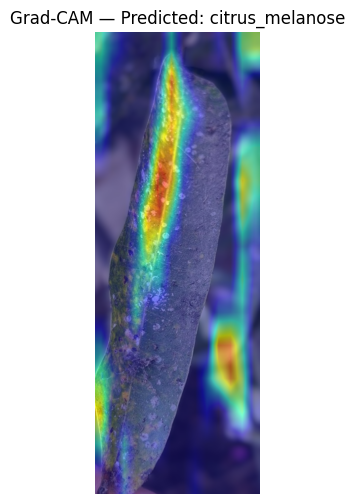

In [75]:
# --- Grad-CAM inference example ---
# Update this path to your image
image_path = r"C:/Users/loaim/OneDrive/Desktop/img1.jpeg"
image, input_tensor = prepare_image(image_path, val_transform, device)

# Enable gradients for the input
input_tensor.requires_grad = True

# select an appropriate target layer for the model
if hasattr(model, 'layer4'):
    # Get the last Conv2d layer inside layer4[-1]
    target_layer = model.layer3[-1].conv2
elif hasattr(model, 'conv_block4'):
    # for custom CNN, conv_block4 is a Sequential; hook its last Conv2d by searching
    last_conv = None
    for m in reversed(list(model.conv_block4.modules())):
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            break
    target_layer = last_conv if last_conv is not None else model.conv_block4
else:
    target_layer = list(model.modules())[-1]

gradcam = GradCAM(model, target_layer)
cam, pred_class = gradcam.generate(input_tensor)
overlay = overlay_cam(image, cam)
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"Grad-CAM — Predicted: {full_dataset.classes[pred_class]}")
plt.axis('off')
plt.show()

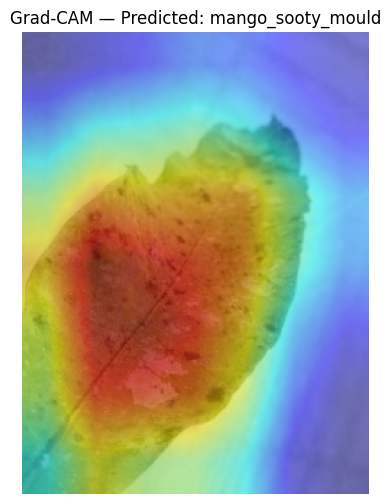

In [76]:
# Grad-CAM inference template — update `image_path` and run

# Replace this with your image path
image_path = r"C:/Users/loaim/OneDrive\Desktop/IMG_20211108_120942 (Custom).jpg"

# Prepare image tensor (uses `prepare_image` and `val_transform` defined earlier in the notebook)
image, input_tensor = prepare_image(image_path, val_transform, device)
input_tensor.requires_grad = True

# Select a sensible target conv layer for the model
if hasattr(model, 'layer4'):
    target_layer = model.layer4[-1].conv2
elif hasattr(model, 'conv_block4'):
    last_conv = None
    for m in reversed(list(model.conv_block4.modules())):
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            break
    target_layer = last_conv if last_conv is not None else model.conv_block4
else:
    target_layer = None
    for m in reversed(list(model.modules())):
        if isinstance(m, torch.nn.Conv2d):
            target_layer = m
            break
    if target_layer is None:
        raise RuntimeError('No Conv2d layer found to attach GradCAM')

# Create GradCAM instance and generate CAM (uses `GradCAM` and `overlay_cam` from the notebook)
gradcam = GradCAM(model, target_layer)
cam, pred_class = gradcam.generate(input_tensor)

# Overlay and show
overlay = overlay_cam(image, cam)
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"Grad-CAM — Predicted: {full_dataset.classes[pred_class]}")
plt.axis('off')
plt.show()
